# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

**Задачи:**
1. Загрузите данные. 
2. Изучите данные. Заполните пропущенные значения и обработайте аномалии в столбцах. Если среди признаков имеются неинформативные, удалите их.
3. Подготовьте выборки для обучения моделей.
4. Обучите разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробуйте разные гиперпараметры.
5. Проанализируйте время обучения, время предсказания и качество моделей.
6. Опираясь на критерии заказчика, выберете лучшую модель, проверьте её качество на тестовой выборке.

**Заказчику важны:**
- качество предсказания;
- скорость предсказания;
- время обучения.

**Примечания:**
* Для оценки качества моделей применяйте метрику RMSE.
* Значение метрики RMSE должно быть меньше 2500.

**План:**

1. Подготовка данных
    * Загрузка
    * Неинформативные Столбцы
    * Дубликаты
    * Аномалии
    * Выборки - перед пропусками чтобы избежать утечку ЦП контрольной выборки
    * Пропуски
    * OHE
2. Обучение моделей
    * LGBM
    * CatBoost
    * LinearRegression
    * RandomForest
3. Анализ моделей - время обучения, время предсказания и RMSE
4. Результаты на контрольной выборке.

**Содержание**<a id='toc0_'></a>    
1. [Подготовка данных](#toc1_)    
1.1. [Загрузка](#toc1_1_)    
1.2. [Неинформативные Столбцы](#toc1_2_)    
1.3. [Дубликаты](#toc1_3_)    
1.4. [Аномалии](#toc1_4_)    
1.4.1. [`price`](#toc1_4_1_)    
1.4.2. [`registration_year`](#toc1_4_2_)    
1.4.3. [`power`](#toc1_4_3_)    
1.4.4. [Выводы](#toc1_4_4_)    
1.5. [Выборки](#toc1_5_)    
1.5.1. [`date_created`](#toc1_5_1_)    
1.5.2. [Признаки, ЦП](#toc1_5_2_)    
1.5.3. [Контрольная выборка](#toc1_5_3_)    
1.6. [Пропуски](#toc1_6_)    
1.6.1. [`brand_model`](#toc1_6_1_)    
1.6.2. [`gearbox`](#toc1_6_2_)    
1.6.3. [`vehicle_type `](#toc1_6_3_)    
1.6.4. [`fuel_type`](#toc1_6_4_)    
1.6.5. [`power`](#toc1_6_5_)    
1.6.6. [`registration_year`](#toc1_6_6_)    
1.6.7. [`repaired`](#toc1_6_7_)    
1.6.8. [Выводы](#toc1_6_8_)    
1.7. [Типы данных](#toc1_7_)    
1.8. [ML подготовка](#toc1_8_)    
1.8.1. [One Hot Encoding](#toc1_8_1_)    
2. [Обучение моделей](#toc2_)    
2.1. [LGBM](#toc2_1_)    
2.1.1. [Базовая модель](#toc2_1_1_)    
2.1.2. [GridSearchCV](#toc2_1_2_)    
2.2. [Cat Boost](#toc2_2_)    
2.2.1. [Базовая модель](#toc2_2_1_)    
2.3. [LinearRegression](#toc2_3_)    
2.4. [RandomForest](#toc2_4_)    
2.4.1. [Базовая модель](#toc2_4_1_)    
2.4.2. [GridSearchCV](#toc2_4_2_)    
3. [Анализ моделей](#toc3_)    
4. [Результаты на контрольной выборке.](#toc4_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=true
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

*Библиотеки. Параметры. Контроль случайности.*

In [99]:
import pandas as pd
import numpy as np
import re
import os
import seaborn as sns
import matplotlib.pyplot as plt
import time
import warnings

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error

from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor


In [100]:
plt.rcParams["figure.figsize"] = (8,8)
plt.rc('axes', titlesize='x-large')

RANDOM = 0

rng = np.random.default_rng(RANDOM)

## 1. <a id='toc1_'></a>[Подготовка данных](#toc0_)

### 1.1. <a id='toc1_1_'></a>[Загрузка](#toc0_)

**Признаки**

date_crawled — дата скачивания анкеты из базы

vehicle_type — тип автомобильного кузова

registration_year — год регистрации автомобиля

gearbox — тип коробки передач

power — мощность (л. с.)

model — модель автомобиля

kilometer — пробег (км)

registration_month — месяц регистрации автомобиля

fuel_type — тип топлива

brand — марка автомобиля

repaired — была машина в ремонте или нет

date_created — дата создания анкеты

number_of_pictures — количество фотографий автомобиля

postal_code — почтовый индекс владельца анкеты (пользователя)

last_seen — дата последней активности пользователя

**Целевой признак**

price — цена (евро)

In [101]:
path_local = 'datasets/'
path_platform = '/datasets/'
path_extra = ''

df_list = [
    'autos.csv'
]

if os.path.exists(path_local) and all(list(map(os.path.exists, map(lambda x: path_local + x, df_list)))):
    df_dir = path_local
    print("Файлы найдены.")
elif os.path.exists(path_platform) and all(list(map(os.path.exists, map(lambda x: path_platform + x, df_list)))):
    df_dir = path_platform
    print("Файлы найдены.")
elif os.path.exists(path_extra) and all(list(map(os.path.exists, map(lambda x: path_extra + x, df_list)))):
    df_dir = path_extra
    print("Файлы найдены.")
elif all(list(map(os.path.exists, df_list))):
    df_dir = ''
    print("Файлы найдены.")
else:
    print("Директория не найдена. Файлы не найдены в текущей.")  

df0 = pd.read_csv(os.path.join(df_dir, 'autos.csv'), parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])

Файлы найдены.


In [102]:

df0.columns = df0.columns.map(lambda x: re.sub(r'(?<!^)(?=[A-Z])', '_', x).lower())

df0 # Оригинал

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19,0,87439,2016-04-07 07:15:26


In [103]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354369 non-null  datetime64[ns]
 1   price               354369 non-null  int64         
 2   vehicle_type        316879 non-null  object        
 3   registration_year   354369 non-null  int64         
 4   gearbox             334536 non-null  object        
 5   power               354369 non-null  int64         
 6   model               334664 non-null  object        
 7   kilometer           354369 non-null  int64         
 8   registration_month  354369 non-null  int64         
 9   fuel_type           321474 non-null  object        
 10  brand               354369 non-null  object        
 11  repaired            283215 non-null  object        
 12  date_created        354369 non-null  datetime64[ns]
 13  number_of_pictures  354369 no

In [104]:
df0.isnull().sum()

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired              71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

In [105]:
df0.describe(include=[np.number, np.datetime64], datetime_is_numeric=True)

,date_crawled,price,registration_year,power,kilometer,registration_month,date_created,number_of_pictures,postal_code,last_seen
count,354369,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369,354369.0,354369.000000,354369
mean,2016-03-21 12:58:10.450648320,4416.656776,2004.234448,110.094337,128211.172535,5.714645,2016-03-20 19:12:07.753274112,0.0,50508.689087,2016-03-29 23:51:00.667456768
min,2016-03-05 14:06:22,0.000000,1000.000000,0.000000,5000.000000,0.000000,2014-03-10 00:00:00,0.0,1067.000000,2016-03-05 14:15:08
25%,2016-03-13 11:52:33,1050.000000,1999.000000,69.000000,125000.000000,3.000000,2016-03-13 00:00:00,0.0,30165.000000,2016-03-23 02:50:03
50%,2016-03-21 17:50:55,2700.000000,2003.000000,105.000000,150000.000000,6.000000,2016-03-21 00:00:00,0.0,49413.000000,2016-04-03 15:15:51
75%,2016-03-29 14:37:20,6400.000000,2008.000000,143.000000,150000.000000,9.000000,2016-03-29 00:00:00,0.0,71083.000000,2016-04-06 10:15:19
max,2016-04-07 14:36:58,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,2016-04-07 00:00:00,0.0,99998.000000,2016-04-07 14:58:51
std,NaN,4514.158514,90.227958,189.850405,37905.341530,3.726421,NaN,0.0,25783.096248,NaN


In [106]:
df0[df0.date_created.dt.year < 2016].shape[0]

26

In [107]:
df1 = df0.copy()

In [108]:
df1.drop(df1[df1.date_created.dt.year < 2016].index, inplace=True)

In [109]:
df1.brand.duplicated().sum() == df1.brand.str.lower().duplicated().sum()

True

In [110]:
df1.model.duplicated().sum() == df1.model.str.lower().duplicated().sum()

True

In [111]:
df1['brand_model'] = df1.brand + '_' + df1.model
df1

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen,brand_model
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57,volkswagen_golf
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50,NaN
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46,jeep_grand
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17,volkswagen_golf
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21,skoda_fabia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21,0,2694,2016-03-21 10:42:49,mitsubishi_colt
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14,0,39576,2016-04-06 00:46:52,NaN
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05,0,26135,2016-03-11 18:17:12,smart_fortwo
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19,0,87439,2016-04-07 07:15:26,volkswagen_transporter


**Выводы**

Файл данных загружен. Столбцы переименованы в формат `snake_case`, даты представленные в стандартном формате сохранены в формате `datetime`. Из представленных объявлений, только 26 создано до 2016 года, скопируем ДФ и отбросим их в копии с которой будем работать. Остальные - с января по апрель 2016.  Создан признак  `brand_model` для содействия в анализе данных из `brand` и `model`. Закончим их обработку после пропусков.

Ряд столбцов имеет низкую информационную ценность. В данных есть пропуски и аномалии. Проведём переработку.

### 1.2. <a id='toc1_2_'></a>[Неинформативные Столбцы](#toc0_)

In [112]:
df1.postal_code.unique().shape

(8143,)

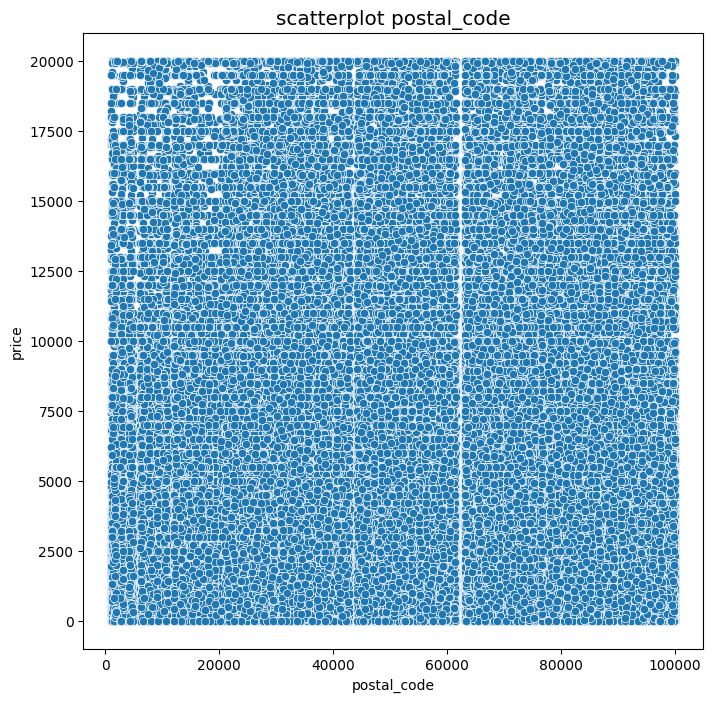

In [113]:
sns.scatterplot(y=df1.price, x=df1.postal_code)
plt.title('scatterplot postal_code');

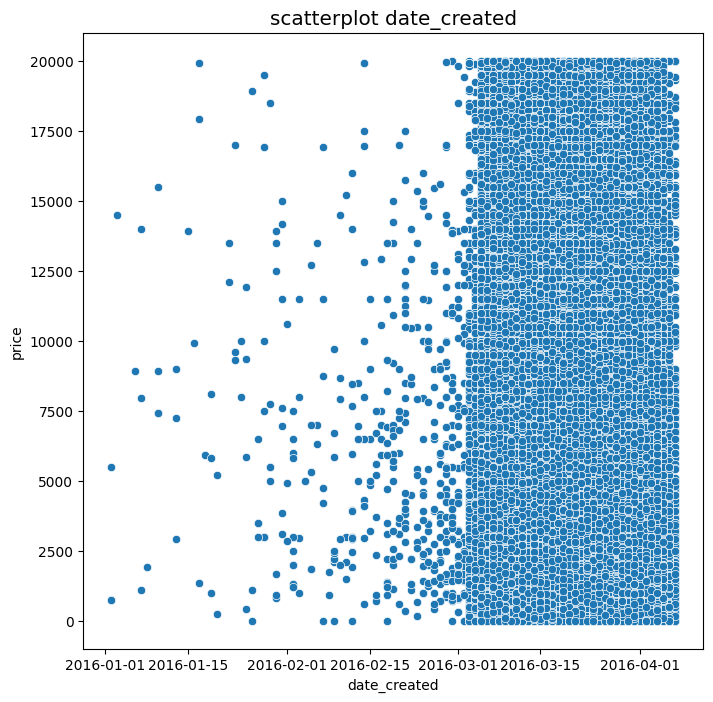

In [114]:
sns.scatterplot(y=df1.price, x=df1.date_created)
plt.title('scatterplot date_created');

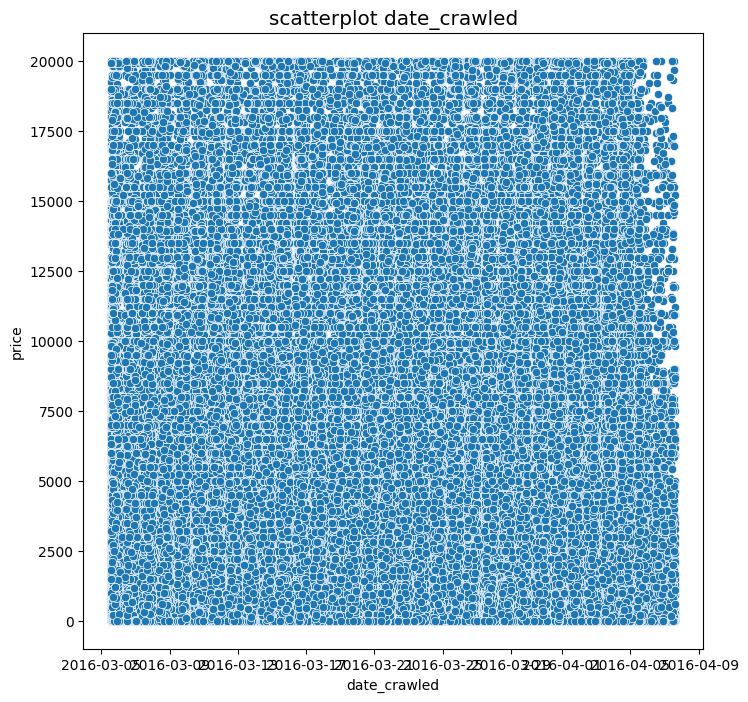

In [115]:
sns.scatterplot(y=df1.price, x=df1.date_crawled)
plt.title('scatterplot date_crawled');

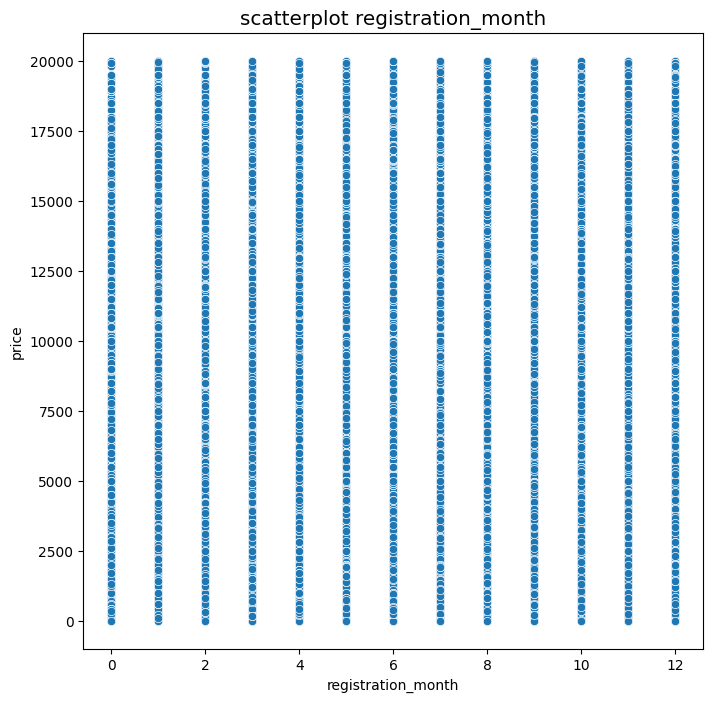

In [116]:
sns.scatterplot(y=df1.price, x=df1.registration_month)
plt.title('scatterplot registration_month');

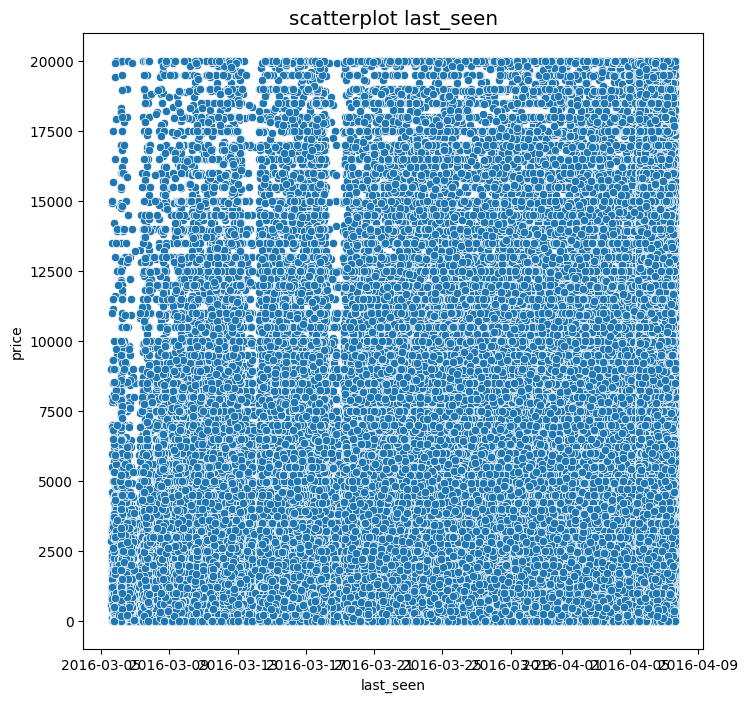

In [117]:
sns.scatterplot(y=df1.price, x=df1.last_seen)
plt.title('scatterplot last_seen');

In [118]:
df1.number_of_pictures.value_counts()

0    354343
Name: number_of_pictures, dtype: int64

In [119]:
df1.drop(['number_of_pictures', 'postal_code', 'registration_month', 'date_crawled', 'last_seen'], axis=1, inplace=True)
df1

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,date_created,brand_model
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN,2016-03-24,volkswagen_golf
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes,2016-03-24,NaN
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN,2016-03-14,jeep_grand
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,2016-03-17,volkswagen_golf
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,2016-03-31,skoda_fabia
...,...,...,...,...,...,...,...,...,...,...,...,...
354364,0,NaN,2005,manual,0,colt,150000,petrol,mitsubishi,yes,2016-03-21,mitsubishi_colt
354365,2200,NaN,2005,NaN,0,NaN,20000,NaN,sonstige_autos,NaN,2016-03-14,NaN
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no,2016-03-05,smart_fortwo
354367,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no,2016-03-19,volkswagen_transporter


**Выводы**

`number_of_pictures`, `postal_code`, `registration_month`, `date_crawled`, `last_seen` удалены т.к. не содержат достаточно полезной информации для оценки стоимости автомобиля.

### 1.3. <a id='toc1_3_'></a>[Дубликаты](#toc0_)

In [120]:
df1.duplicated().sum()

13368

In [121]:
df0.drop(['number_of_pictures', 'postal_code', 'registration_month', 'date_created','date_crawled', 'last_seen'], axis=1).duplicated().sum()

45040

In [122]:
df1.drop_duplicates(subset=df1.columns.drop(['date_created']), inplace=True)

In [123]:
df1.drop(['date_created'], axis=1).duplicated().sum()

0

**Выводы**

Значительное число дубликатов, отличающихся только по малозначимым признакам и дате публикации, скорее всего говорит о парсинге объявлений на один и тот же автомобиль несколько раз из разных источников или в разное время.

### 1.4. <a id='toc1_4_'></a>[Аномалии](#toc0_)

In [124]:
df1.describe(include=[np.number, np.datetime64], datetime_is_numeric=True)

,price,registration_year,power,kilometer,date_created
count,309310.000000,309310.000000,309310.000000,309310.000000,309310
mean,4486.675862,2004.360124,110.977275,127219.601694,2016-03-20 19:44:03.196793600
min,0.000000,1000.000000,0.000000,5000.000000,2016-01-02 00:00:00
25%,1100.000000,1999.000000,69.000000,125000.000000,2016-03-13 00:00:00
50%,2800.000000,2003.000000,105.000000,150000.000000,2016-03-21 00:00:00
75%,6500.000000,2008.000000,143.000000,150000.000000,2016-03-29 00:00:00
max,20000.000000,9999.000000,20000.000000,150000.000000,2016-04-07 00:00:00
std,4564.714960,92.544222,200.975216,38531.645468,NaN


#### 1.4.1. <a id='toc1_4_1_'></a>[`price`](#toc0_)

In [125]:
df1.drop(df1[df1.price == 0 ].index, inplace=True)

In [126]:
df1.price.min()

1

In [127]:
df1.drop(df1[df1.price < df1.price.quantile(.01)].index, inplace=True)

In [128]:
df1.price.value_counts().sort_index().head(10)

100    939
101      4
105      3
106      1
108      1
110     34
111     15
112      1
115      4
117      3
Name: price, dtype: int64

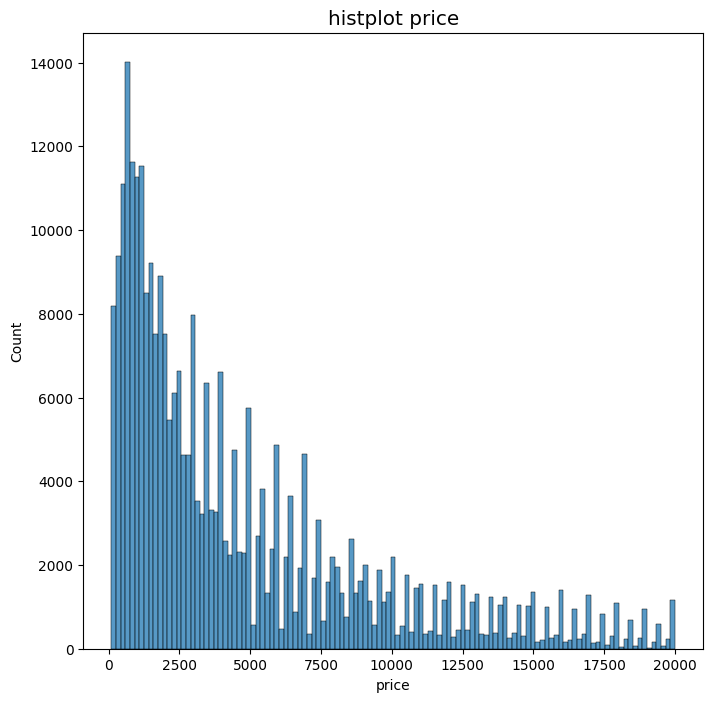

In [129]:
sns.histplot(x=df1.price)
plt.title('histplot price');

Text(0.5, 1.0, 'boxplot price')

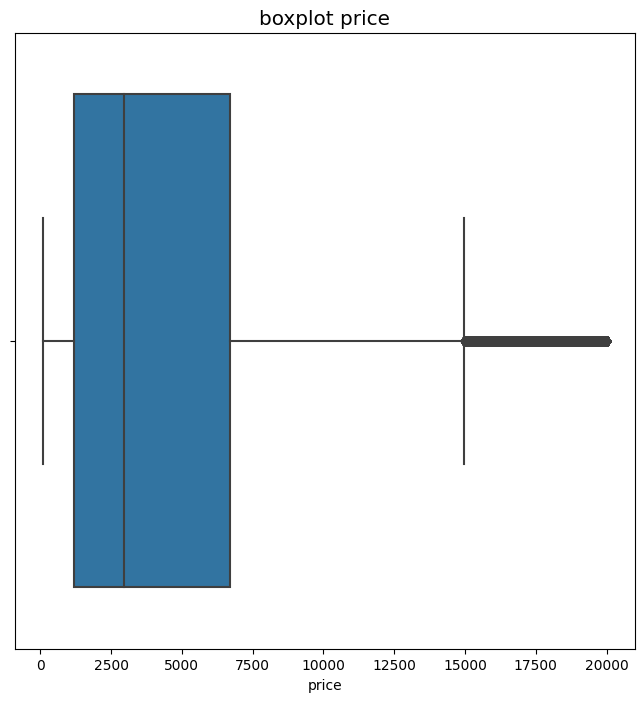

In [130]:
sns.boxplot(x=df1.price);
plt.title('boxplot price')

Text(0.5, 1.0, 'boxplot price < q10')

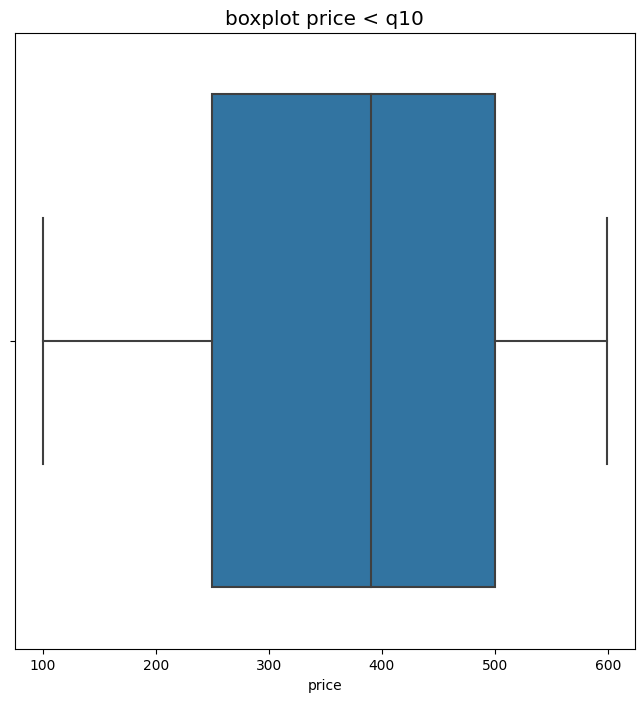

In [131]:
sns.boxplot(x=(df1.price[df1.price < df1.price.quantile(.1)]));
plt.title('boxplot price < q10')

Text(0.5, 1.0, 'boxplot price > q90')

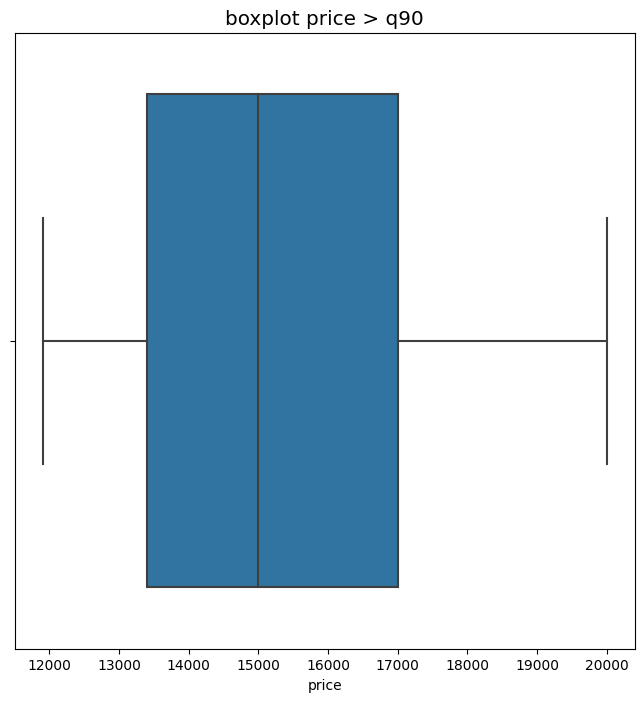

In [132]:
sns.boxplot(x=(df1.price[df1.price > df1.price.quantile(.9)]));
plt.title('boxplot price > q90')

#### 1.4.2. <a id='toc1_4_2_'></a>[`registration_year`](#toc0_)

In [133]:
(df1.registration_year < 1950).sum()

141

In [134]:
df1.registration_year.where(df1.registration_year > 1949, pd.NA, inplace=True)

In [135]:
(df1.registration_year > 2016).sum()

12832

In [136]:
df1.registration_year.where(df1.registration_year < 2017, pd.NA, inplace=True)

In [137]:
(df1.registration_year < 1990).sum()

8188

#### 1.4.3. <a id='toc1_4_3_'></a>[`power`](#toc0_)

In [138]:
df1.power.where((df1.power !=0) &  (df1.power < 1521), pd.NA, inplace=True) # max 1521 PferdStarke in 2016

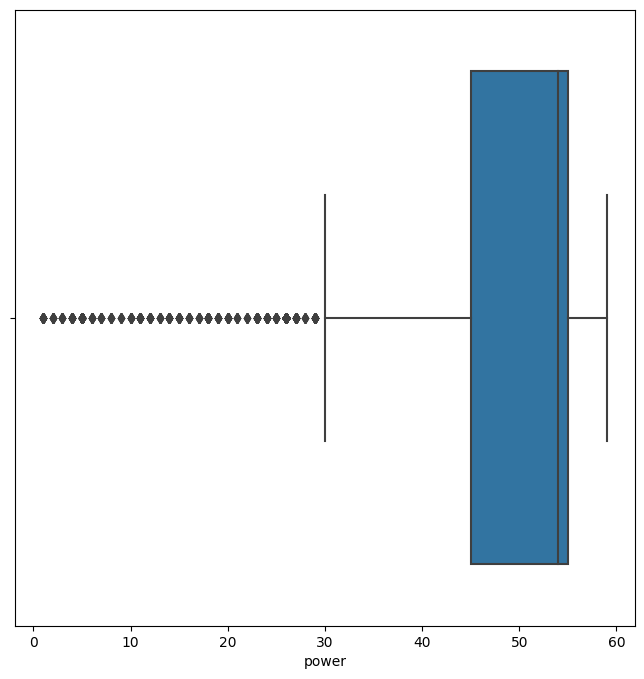

In [139]:
sns.boxplot(x=(df1.power[df1.power < df1.power.quantile(.1)]));

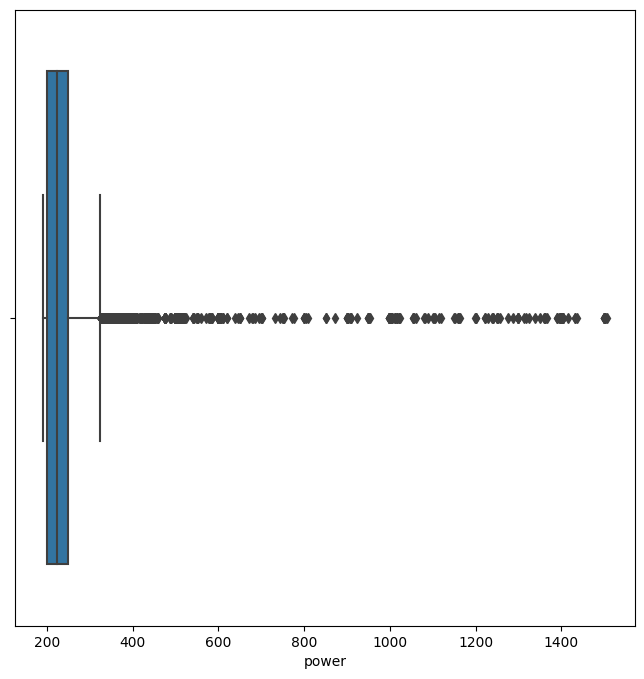

In [140]:
sns.boxplot(x=(df1.power[df1.power > df1.power.quantile(.9)]));

In [141]:
df1.power.where((df1.power > 9), pd.NA, inplace=True) # max 1500 in 2016

In [142]:
df1[(df1.power < 16) & (df1.model != 'other')]

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,date_created,brand_model
11852,1999,coupe,1964.0,manual,10.0,NaN,150000,petrol,sonstige_autos,NaN,2016-03-18,NaN
28746,700,NaN,2016.0,manual,10.0,vectra,150000,NaN,opel,NaN,2016-03-30,opel_vectra
29218,3300,wagon,2008.0,manual,15.0,fabia,150000,gasoline,skoda,NaN,2016-03-12,skoda_fabia
30463,12900,sedan,2011.0,manual,12.0,golf,80000,gasoline,volkswagen,no,2016-03-31,volkswagen_golf
40412,3500,other,2010.0,auto,15.0,NaN,5000,petrol,sonstige_autos,NaN,2016-03-06,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
305206,5350,wagon,2005.0,manual,13.0,a4,150000,gasoline,audi,no,2016-04-03,audi_a4
305924,1300,other,1986.0,manual,11.0,NaN,40000,petrol,sonstige_autos,NaN,2016-03-09,NaN
311830,1400,NaN,2016.0,manual,12.0,corsa,150000,petrol,opel,no,2016-03-18,opel_corsa
321943,8000,suv,2002.0,manual,13.0,navara,150000,gasoline,nissan,no,2016-03-29,nissan_navara


In [143]:
print(df1.duplicated().sum())
df1.drop_duplicates(inplace=True)

4


#### 1.4.4. <a id='toc1_4_4_'></a>[Выводы](#toc0_)

In [144]:
df1.describe(include=[np.number, np.datetime64], datetime_is_numeric=True)

,price,registration_year,power,kilometer,date_created
count,298025.000000,285055.000000,265887.000000,298025.000000,298025
mean,4656.303689,2002.668362,121.785518,127468.719067,2016-03-20 19:39:45.814612992
min,100.000000,1950.000000,10.000000,5000.000000,2016-01-02 00:00:00
25%,1200.000000,1999.000000,80.000000,125000.000000,2016-03-13 00:00:00
50%,2950.000000,2003.000000,113.000000,150000.000000,2016-03-21 00:00:00
75%,6700.000000,2007.000000,150.000000,150000.000000,2016-03-29 00:00:00
max,20000.000000,2016.000000,1506.000000,150000.000000,2016-04-07 00:00:00
std,4564.739712,6.899683,59.184379,37944.310135,NaN


Устранён ряд аномалий, отброшены объявления с неправдоподобно низкими ценами, они вредны для модели. Невозможно с уверенностью заявлять о качестве данных, там где цена высокая, оставим их. Заменим пропусками регистрацию автомобиля до 1950 или после 2016, скорее всего это ложные данные. То же самое с информацией о мощности двигателя выше 1500 л.с. (1521 - PferdStarke) или ниже 10. Убедимся что в новой таблице нет дубликатов

### 1.5. <a id='toc1_5_'></a>[Выборки](#toc0_)

#### 1.5.1. <a id='toc1_5_1_'></a>[`date_created`](#toc0_)

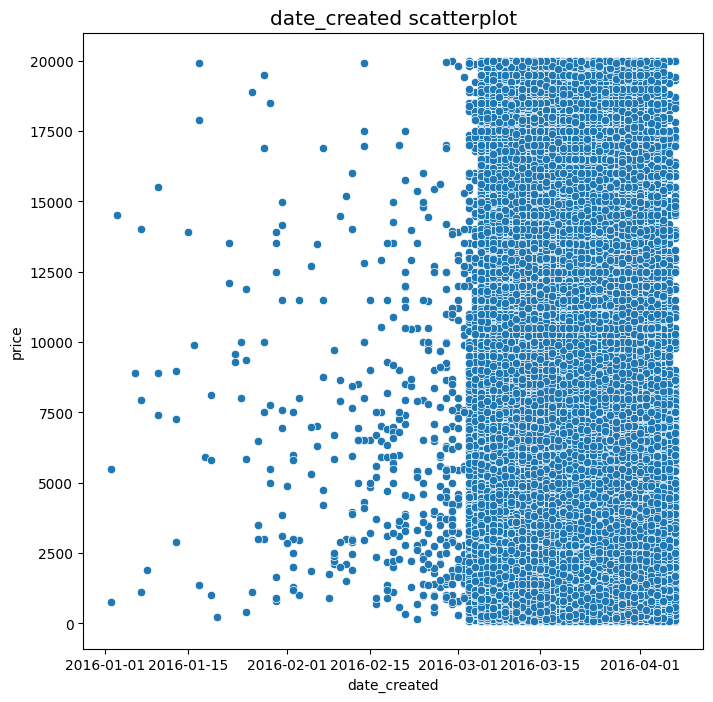

In [145]:
sns.scatterplot(y=df1.price, x=df1.date_created);
plt.title('date_created scatterplot');

In [146]:
df1[df1.date_created < '2016-03'].shape

(390, 12)

In [147]:
df1.drop('date_created', axis=1, inplace=True)
print(df1.duplicated().sum())
df1.drop_duplicates(inplace=True)

117


**Выводы**

Практически все объекты были созданы в марте-апреле 2016 года, как следствие нет нужды разбивать выборки по времени. 390 объектов до марта представляют достаточно свежую информацию, нет смысла отбрасывать. В дальнейшем столбец не понадобится, отбросим его и убедимся что в новой таблице нет дубликатов.

#### 1.5.2. <a id='toc1_5_2_'></a>[Признаки, ЦП](#toc0_)

In [148]:
features = df1.drop(['price'], axis=1)
features

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,brand_model
0,NaN,1993.0,manual,NaN,golf,150000,petrol,volkswagen,NaN,volkswagen_golf
1,coupe,2011.0,manual,190.0,NaN,125000,gasoline,audi,yes,NaN
2,suv,2004.0,auto,163.0,grand,125000,gasoline,jeep,NaN,jeep_grand
3,small,2001.0,manual,75.0,golf,150000,petrol,volkswagen,no,volkswagen_golf
4,small,2008.0,manual,69.0,fabia,90000,gasoline,skoda,no,skoda_fabia
...,...,...,...,...,...,...,...,...,...,...
354362,sedan,2004.0,manual,225.0,leon,150000,petrol,seat,yes,seat_leon
354365,NaN,2005.0,NaN,NaN,NaN,20000,NaN,sonstige_autos,NaN,NaN
354366,convertible,2000.0,auto,101.0,fortwo,125000,petrol,smart,no,smart_fortwo
354367,bus,1996.0,manual,102.0,transporter,150000,gasoline,volkswagen,no,volkswagen_transporter


In [149]:
target = df1.price
target

0           480
1         18300
2          9800
3          1500
4          3600
          ...  
354362     3200
354365     2200
354366     1199
354367     9200
354368     3400
Name: price, Length: 297908, dtype: int64

#### 1.5.3. <a id='toc1_5_3_'></a>[Контрольная выборка](#toc0_)

In [150]:
feat_train, feat_test, targ_train, targ_test = train_test_split(features, target, test_size=.2, random_state=RANDOM)

In [151]:
feat_train.index.intersection(df1.index)

Int64Index([348615,  94253,  22319,  45259, 301062, 258436,  15496, 165147,
             17270, 188346,
            ...
            168084,  17967,  87085, 192654, 243879, 243245,  94013, 135770,
            170757, 130407],
           dtype='int64', length=238326)

In [152]:
def renew_samples():
    global df1, feat_train, feat_test, targ_train, targ_test
    print('Дубликатов выброшено:', df1.duplicated().sum())
    df1.drop_duplicates(inplace=True)
    feat_train = df1.drop(['price'], axis=1).loc[feat_train.index.intersection(df1.index)].dropna(how='all')
    feat_test = df1.drop(['price'], axis=1).loc[feat_test.index.intersection(df1.index)].dropna(how='all')
    targ_train = df1.price.loc[targ_train.index.intersection(df1.index)].dropna(how='all')
    targ_test = df1.price.loc[targ_test.index.intersection(df1.index)].dropna(how='all')

**Выводы**

Чтобы избежать утечки ЦП из контрольной выборки при выборе способа заполнить пропуски, разобьём на выборки перед обработкой пропусков.

### 1.6. <a id='toc1_6_'></a>[Пропуски](#toc0_)

In [153]:
df1.isnull().sum()

price                    0
vehicle_type         30510
registration_year    12861
gearbox              14447
power                32097
model                16228
kilometer                0
fuel_type            27008
brand                    0
repaired             58855
brand_model          16228
dtype: int64

In [154]:
df1.corrwith(df1.price)

price                1.000000
registration_year    0.436009
power                0.448988
kilometer           -0.349837
dtype: float64

#### 1.6.1. <a id='toc1_6_1_'></a>[`brand_model`](#toc0_)

In [155]:
df1.model.fillna('other', inplace=True)
df1.brand_model.fillna(df1.brand + '_' + df1.model, inplace=True)
df1.drop(['brand', 'model'], axis=1, inplace=True)
renew_samples()


Дубликатов выброшено: 94


**Выводы**

Пометим пропуски `model` как другие (`other`), заполним `brand_model`, отбросим `brand`, `model`.

#### 1.6.2. <a id='toc1_6_2_'></a>[`gearbox`](#toc0_)

In [156]:
df1.gearbox.unique()

array(['manual', 'auto', nan], dtype=object)

In [157]:
df1.rename({'gearbox': 'gearbox_auto'}, axis=1, inplace=True)
df1.gearbox_auto.replace('auto', True, inplace=True)
df1.gearbox_auto.replace('manual', False, inplace=True)
renew_samples()



Дубликатов выброшено: 0


In [158]:
df1.gearbox_auto.value_counts(normalize=True)

False    0.795758
True     0.204242
Name: gearbox_auto, dtype: float64

In [159]:
feat_train.gearbox_auto.dropna().astype(bool).corr(targ_train)

0.2418443384935292

In [160]:
feat_train.gearbox_auto.fillna(False).corr(targ_train)

0.2469053365258376

In [161]:
feat_train.gearbox_auto.fillna(
    pd.DataFrame(
        feat_train.groupby('brand_model').gearbox_auto.agg(lambda x: pd.Series(x).mode().iloc[0])[feat_train.brand_model]
        .reset_index(drop=True)).set_index(feat_train.brand_model.index).gearbox_auto
).corr(targ_train)

0.24172099575900555

In [162]:
df1.gearbox_auto.fillna(
    pd.DataFrame(df1.groupby('brand_model').gearbox_auto.agg(lambda x: pd.Series(x).mode().iloc[0])[df1.brand_model].reset_index(drop=True)).set_index(df1.brand_model.index).gearbox_auto,
    inplace=True
    )
renew_samples()

Дубликатов выброшено: 959


**Выводы**

Признак приведён к `bool` формату, переименован в `gearbox_auto`. Наблюдается небольшая корреляция признака `gearbox_auto` с ЦП `price`, если оценивать их без учёта пропусков. Заполнили на основе моды моделей автомобилей, корреляция сохранилась до 4 знака. Заполнение отрицательными даёт лучше корреляцию, с большей вероятностью исказит распределение.

#### 1.6.3. <a id='toc1_6_3_'></a>[`vehicle_type `](#toc0_)

In [163]:
df1.vehicle_type.value_counts(normalize=True)

sedan          0.285177
small          0.244155
wagon          0.205353
bus            0.094945
convertible    0.066791
coupe          0.052989
suv            0.039582
other          0.011007
Name: vehicle_type, dtype: float64

In [164]:
df1.vehicle_type.fillna(
    pd.DataFrame(df1.groupby('brand_model').vehicle_type.agg(lambda x: pd.Series(x).mode().iloc[0])[df1.brand_model].reset_index(drop=True)).set_index(df1.vehicle_type.index).vehicle_type
    ).value_counts(normalize=True) - df1.vehicle_type.value_counts(normalize=True)

sedan          0.011328
small          0.007854
wagon         -0.009938
bus            0.003197
convertible   -0.006111
coupe         -0.002850
suv           -0.002368
other         -0.001110
Name: vehicle_type, dtype: float64

In [165]:
df1.vehicle_type.fillna(
    pd.DataFrame(df1.groupby('brand_model').vehicle_type.agg(lambda x: pd.Series(x).mode().iloc[0])[df1.brand_model].reset_index(drop=True)).set_index(df1.vehicle_type.index).vehicle_type,
    inplace=True
    )
renew_samples()

Дубликатов выброшено: 257


**Выводы**

Заполнили на основе моды моделей автомобилей, изменения в распределении минимальны. 

#### 1.6.4. <a id='toc1_6_4_'></a>[`fuel_type`](#toc0_)

In [166]:
df1.fuel_type.value_counts(normalize=True)

petrol      0.671205
gasoline    0.307669
lpg         0.017582
cng         0.001876
hybrid      0.000797
other       0.000556
electric    0.000315
Name: fuel_type, dtype: float64

In [167]:
df1.fuel_type.fillna(
    pd.DataFrame(df1.groupby('brand_model').fuel_type.agg(lambda x: pd.Series(x).mode().iloc[0])[df1.brand_model].reset_index(drop=True)).set_index(df1.fuel_type.index).fuel_type
    ).value_counts(normalize=True) - df1.fuel_type.value_counts(normalize=True)

petrol      0.015536
gasoline   -0.013624
lpg        -0.001591
cng        -0.000170
hybrid     -0.000072
other      -0.000050
electric   -0.000029
Name: fuel_type, dtype: float64

In [168]:
df1.fuel_type.fillna(
    pd.DataFrame(df1.groupby('brand_model').fuel_type.agg(lambda x: pd.Series(x).mode().iloc[0])[df1.brand_model].reset_index(drop=True)).set_index(df1.fuel_type.index).fuel_type,
    inplace=True
    )
renew_samples()

Дубликатов выброшено: 2400


**Выводы**

Заполнили на основе моды моделей автомобилей, изменения в распределении минимальны. 

#### 1.6.5. <a id='toc1_6_5_'></a>[`power`](#toc0_)

In [169]:
df1.power = df1.power.astype('Int64')
renew_samples()

Дубликатов выброшено: 0


In [170]:
feat_train.power.dropna().astype('int32').corr(targ_train[feat_train.power.dropna().index].astype('int32')) # без np типа данных не работает

0.44712198688650723

In [171]:
temp_power = pd.DataFrame(
    pd.to_numeric(feat_train.groupby('brand_model').power.agg(lambda x:  pd.Series(x).mode()), errors='coerce')[feat_train.brand_model]
    .reset_index(drop=True)).set_index(feat_train.power.index).power
temp_power = temp_power.dropna()
temp_power.corr(targ_train[temp_power.index])

0.32599626990866015

In [172]:
with warnings.catch_warnings(): # Для того чтобы не нарушать индексацию и избежать предупреждения.
    warnings.simplefilter("ignore", category=RuntimeWarning) 
    temp_power = pd.to_numeric(pd.DataFrame(
        feat_train.groupby('brand_model').power.agg(lambda x:  pd.Series(x).median())[feat_train.brand_model]
        .reset_index(drop=True)).set_index(feat_train.power.index).power
        )
temp_power = temp_power.dropna()
temp_power.corr(targ_train[feat_train.power.dropna().index])

0.33952630237707127

Text(0.5, 1.0, 'histplot')

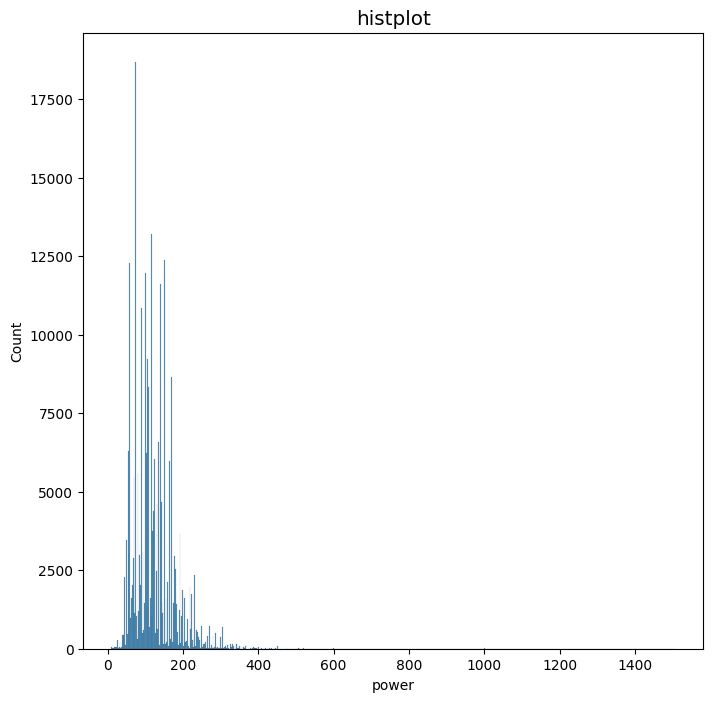

In [173]:
sns.histplot(df1.power)
plt.title('histplot')

In [174]:
df1.power.describe()

count    263170.000000
mean        122.071509
std          59.241651
min          10.000000
25%          80.000000
50%         114.000000
75%         150.000000
max        1506.000000
Name: power, dtype: float64

In [175]:
temp_power = feat_train.power.fillna(pd.Series(np.round(rng.normal(122, 59, feat_train.shape[0])), index=feat_train.index)).astype(int)

In [176]:
temp_power.corr(targ_train)

0.4047957807478149

In [177]:
temp_power = df1.power.fillna(pd.Series(np.round(rng.normal(122, 59, df1.shape[0])), index=df1.index)).astype(int)
df1.power.fillna(temp_power, inplace=True)
renew_samples()

Дубликатов выброшено: 50


**Выводы**

Имеет место значительная корреляция, и большой разброс значений. Заполнение пропусков в данных условиях ухудшает качество. Возможно имеет смысл создать 2 модели, одну для объектов с данными о мощности, другую для объектов без, однако в рамках проекта заполним случайными значениями нормально распределёнными близко к среднему.

#### 1.6.6. <a id='toc1_6_6_'></a>[`registration_year`](#toc0_)

In [178]:
feat_train.registration_year.corr(targ_train)

0.4375682784578871

In [179]:
pd.DataFrame(feat_train.groupby('brand_model')
             .registration_year.agg(lambda x:  pd.Series(x).mode().iloc[0])[feat_train.brand_model]
             .reset_index(drop=True)
             ).set_index(feat_train.registration_year.index).registration_year.corr(targ_train)

0.21080522336913995

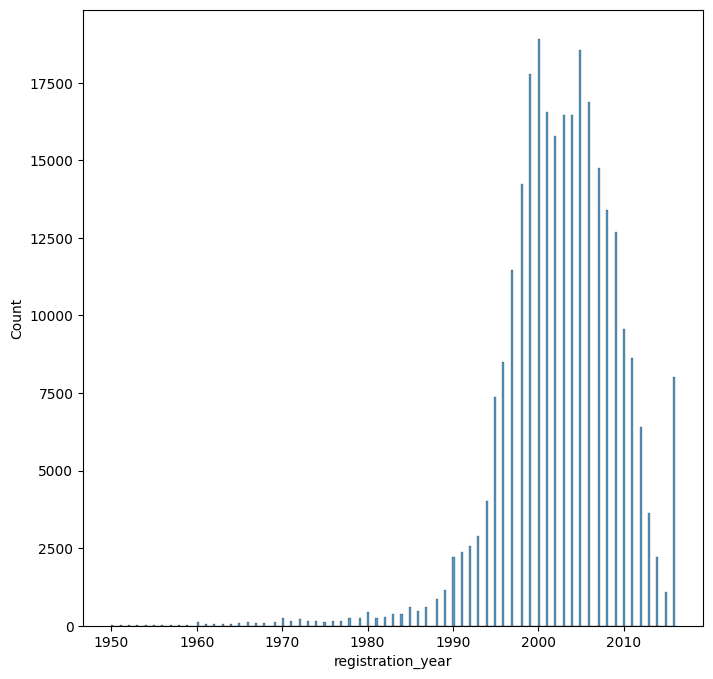

In [180]:
sns.histplot(df1.registration_year);

In [181]:
df1.registration_year.isna().value_counts(normalize=True)

False    0.957576
True     0.042424
Name: registration_year, dtype: float64

In [182]:
df1.registration_year.describe()

count    281669.000000
mean       2002.678861
std           6.903202
min        1950.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: registration_year, dtype: float64

In [183]:
temp_year = feat_train.registration_year.fillna(pd.Series(np.round(rng.normal(2004, 7, feat_train.shape[0])), index=feat_train.index)).astype(int)
temp_year.corr(targ_train)

0.41919514713365047

In [184]:
temp_year = df1.registration_year.fillna(pd.Series(np.round(rng.normal(2004, 7, df1.shape[0])), index=df1.index)).astype(int)
df1.registration_year.fillna(temp_year, inplace=True)
renew_samples()

Дубликатов выброшено: 238


**Выводы**

Несмотря на длинный левый хвост, распределение в целом нормальное, заполним случайными значениями близкими к нему, чтобы сохранить данные.

#### 1.6.7. <a id='toc1_6_7_'></a>[`repaired`](#toc0_)

In [185]:
df1.repaired.replace('yes', True, inplace=True)
df1.repaired.replace('no', False, inplace=True)
renew_samples()

Дубликатов выброшено: 0


In [186]:
feat_train.repaired.dropna().astype(bool).corr(targ_train)

-0.2452960276033469

In [187]:

repaired_backup = df1.repaired.copy()
df1.loc[:, 'repaired_unknown'] = df1.repaired.isna()
df1.repaired.fillna(False, inplace=True)
renew_samples()

Дубликатов выброшено: 0


**Выводы**

Столбец приведён к `bool` типу данных. Наблюдается небольшая негативная корреляция признака `repaired` с ЦП `price`, если оценивать их без учёта пропусков. Примечательно, что заполнение случайными значениями с вероятностью 50%, сохраняет корреляцию лучше чем заполнение с вероятностью представленной в выборке, возможно среди пропусков значительно больше отремонтированных машин.

Как альтернатива, можно создать отдельный логический признак, показывающий отсутствие данных о починке.  

#### 1.6.8. <a id='toc1_6_8_'></a>[Выводы](#toc0_)

In [188]:
df1.isna().sum()

price                0
vehicle_type         0
registration_year    0
gearbox_auto         0
power                0
kilometer            0
fuel_type            0
repaired             0
brand_model          0
repaired_unknown     0
dtype: int64

Пропуски заполнены, данные довольно сложные и имеют значительные объем пропусков в нескольких столбцах, что скорее всего негативно скажется на качестве модели. Убедились что в новой таблице нет дубликатов.

### 1.7. <a id='toc1_7_'></a>[Типы данных](#toc0_)

In [189]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 293910 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              293910 non-null  int64  
 1   vehicle_type       293910 non-null  object 
 2   registration_year  293910 non-null  float64
 3   gearbox_auto       293910 non-null  bool   
 4   power              293910 non-null  Int64  
 5   kilometer          293910 non-null  int64  
 6   fuel_type          293910 non-null  object 
 7   repaired           293910 non-null  bool   
 8   brand_model        293910 non-null  object 
 9   repaired_unknown   293910 non-null  bool   
dtypes: Int64(1), bool(3), float64(1), int64(2), object(3)
memory usage: 27.1+ MB


In [190]:
df1[df1.select_dtypes(np.number).columns] = df1[df1.select_dtypes(np.number).columns].astype(int)
df1[df1.select_dtypes('O').columns] = df1[df1.select_dtypes('O').columns].astype('category')
renew_samples()

Дубликатов выброшено: 0


In [191]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 293910 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   price              293910 non-null  int32   
 1   vehicle_type       293910 non-null  category
 2   registration_year  293910 non-null  int32   
 3   gearbox_auto       293910 non-null  bool    
 4   power              293910 non-null  int32   
 5   kilometer          293910 non-null  int32   
 6   fuel_type          293910 non-null  category
 7   repaired           293910 non-null  bool    
 8   brand_model        293910 non-null  category
 9   repaired_unknown   293910 non-null  bool    
dtypes: bool(3), category(3), int32(4)
memory usage: 16.8 MB


**Выводы**

Все признаки имеют уместный тип данных.

### 1.8. <a id='toc1_8_'></a>[ML подготовка](#toc0_)

#### 1.8.1. <a id='toc1_8_1_'></a>[One Hot Encoding](#toc0_)

In [192]:
categorical_features = list(feat_test.select_dtypes('category').columns)
categorical_features_short = list(feat_test.select_dtypes('category').columns.drop('brand_model'))

In [193]:
df1.vehicle_type.cat.categories

Index(['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv',
       'wagon'],
      dtype='object')

In [194]:
df1.fuel_type.cat.categories

Index(['cng', 'electric', 'gasoline', 'hybrid', 'lpg', 'other', 'petrol'], dtype='object')

In [195]:
df1.brand_model.cat.categories

Index(['alfa_romeo_145', 'alfa_romeo_147', 'alfa_romeo_156', 'alfa_romeo_159',
       'alfa_romeo_other', 'alfa_romeo_spider', 'audi_100', 'audi_200',
       'audi_80', 'audi_90',
       ...
       'volkswagen_up', 'volvo_850', 'volvo_c_reihe', 'volvo_other',
       'volvo_s60', 'volvo_v40', 'volvo_v50', 'volvo_v60', 'volvo_v70',
       'volvo_xc_reihe'],
      dtype='object', length=298)

In [196]:
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')

def ohe_samples(feat_train, feat_test, short):
    if short:
        cat_feat = categorical_features_short
    else: 
        cat_feat = categorical_features
    ohe.fit(feat_train[cat_feat])

    return ohe_drop_transform_concat(feat_train, cat_feat), ohe_drop_transform_concat(feat_test, cat_feat)  


def ohe_drop_transform_concat(feats, cat_feat):
    
    return pd.concat(
        [feats.reset_index(drop=True).drop(categorical_features, axis=1),
        pd.DataFrame(ohe.transform(feats[cat_feat]))], 
        axis=1
    )

feat_train_ohe, feat_test_ohe = ohe_samples(feat_train, feat_test, False)

feat_train_ohe_short, feat_test_ohe_short = ohe_samples(feat_train, feat_test, True)

for sample in [feat_train_ohe, feat_test_ohe, feat_train_ohe_short, feat_test_ohe_short]:
    sample.columns = sample.columns.astype(str)

**Выводы**

Признак brand_model содержит 298 уникальных категорий. Это может значительно повлиять на работу алгоритма. Закодируем 2 набора OHE признаков, один без него, один с ним.

## 2. <a id='toc2_'></a>[Обучение моделей](#toc0_)

In [197]:
def model_execute_cross_val(model, feat_train, targ_train):
    cross_val = cross_validate(model, feat_train, targ_train, cv=3, n_jobs=3, scoring='neg_root_mean_squared_error')
    return pd.DataFrame([[cross_val['fit_time'].mean(), cross_val['score_time'].mean(), - cross_val['test_score'].mean()]],
                        index=[f'{type(model).__name__}'],
                        columns=['Время Обучения', 'Время Предсказания', 'RMSE'])

In [198]:
model_val_scores = pd.DataFrame(columns=['Время Обучения', 'Время Предсказания', 'RMSE'])

**Выводы**

Для удобства работы с базовыми вариантами моделей, определена функция возвращающая интересующие заказчика показатели.

Создан ДФ для хранения показателей разных моделей.

### 2.1. <a id='toc2_1_'></a>[LGBM](#toc0_)

In [199]:
lgbm = LGBMRegressor(random_state=RANDOM)

#### 2.1.1. <a id='toc2_1_1_'></a>[Базовая модель](#toc0_)

In [200]:
model_execute_cross_val(lgbm, feat_train, targ_train)

,Время Обучения,Время Предсказания,RMSE
LGBMRegressor,1.675463,0.254917,1840.057402


In [201]:
model_execute_cross_val(lgbm, feat_train.drop('brand_model', axis=1), targ_train)

,Время Обучения,Время Предсказания,RMSE
LGBMRegressor,1.443198,0.330892,2091.267551


In [202]:
feat_train_temp = pd.concat([feat_train, df0.loc[feat_train.index, ['model', 'brand']].astype('category')], axis=1)
feat_test_temp = pd.concat([feat_test, df0.loc[feat_test.index, ['model', 'brand']].astype('category')], axis=1)

In [203]:
evals = model_execute_cross_val(lgbm, feat_train_temp, targ_train)
model_val_scores.loc[evals.index[0], :] = evals.values
model_val_scores 


,Время Обучения,Время Предсказания,RMSE
LGBMRegressor,1.937382,0.251416,1831.816841


**Выводы**

RMSE базовой модели на проверочной выборке ниже требуемого проектом, однако в сравнении со средней ценой около 4400 говорит о достаточно неточной модели. По результатам видно, что без `brand_model`, модель работает намного хуже, а возвращение признаков `brand`, `model` слегка улучшает модель, не сильно изменяя время работы.

#### 2.1.2. <a id='toc2_1_2_'></a>[GridSearchCV](#toc0_)

In [204]:
parameters = {
    'num_leaves': [31, 20, 40],
    'max_depth': [-1, 5, 10],
    'n_estimators' : [100, 50, 150]    
    }
clf_lgbm = GridSearchCV(lgbm, parameters, verbose=2, scoring='neg_root_mean_squared_error', cv=3, n_jobs=4) #classifier
start_time = time.time()
clf_lgbm.fit(feat_train_temp, targ_train)
grid_search_cv_time = time.time() - start_time
evals = pd.DataFrame([[
    clf_lgbm.cv_results_['mean_fit_time'][clf_lgbm.best_index_],
    clf_lgbm.cv_results_['mean_score_time'][clf_lgbm.best_index_],
    -clf_lgbm.best_score_]],
    index=[f'{type(clf_lgbm).__name__} {type(lgbm).__name__}'],
    columns=['Время Обучения', 'Время Предсказания', 'RMSE'])
model_val_scores.loc[evals.index[0], :] = evals.values
display(pd.DataFrame([clf_lgbm.best_params_.values()], columns=clf_lgbm.best_params_.keys(), index=["Гиперпараметры Лучшей Модели"]))
display(model_val_scores)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 913
[LightGBM] [Info] Number of data points in the train set: 235095, number of used features: 11
[LightGBM] [Info] Start training from score 4687.399664


,max_depth,n_estimators,num_leaves
Гиперпараметры Лучшей Модели,-1,150,40


,Время Обучения,Время Предсказания,RMSE
LGBMRegressor,1.937382,0.251416,1831.816841
GridSearchCV LGBMRegressor,4.191215,0.311442,1801.645522


**Выводы**

С помощью перебора гиперпараметров и кросс валидации удалось понизить RMSE.

### 2.2. <a id='toc2_2_'></a>[Cat Boost](#toc0_)

In [205]:
cat_boost = CatBoostRegressor(random_state=RANDOM, cat_features = categorical_features, verbose=50)

#### 2.2.1. <a id='toc2_2_1_'></a>[Базовая модель](#toc0_)

In [206]:
cross_cat = cross_validate(cat_boost, feat_train, targ_train, scoring='neg_root_mean_squared_error', cv=3, n_jobs=3, verbose=2)
evals = pd.DataFrame([[cross_cat['fit_time'].mean(), cross_cat['score_time'].mean(), - cross_cat['test_score'].mean()]],
                     index=[f'{type(cat_boost).__name__}'],
                     columns=['Время Обучения', 'Время Предсказания', 'RMSE'])
model_val_scores.loc[evals.index[0], :] = evals.values
model_val_scores

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  3.3min finished


,Время Обучения,Время Предсказания,RMSE
LGBMRegressor,1.937382,0.251416,1831.816841
GridSearchCV LGBMRegressor,4.191215,0.311442,1801.645522
CatBoostRegressor,193.241939,0.478640,1840.834313


In [207]:
cat_boost_2 = CatBoostRegressor(random_state=RANDOM, cat_features = categorical_features_short, verbose=50)
cross_cat_2 = cross_validate(cat_boost_2, feat_train.drop(['brand_model'], axis=1), targ_train, scoring='neg_root_mean_squared_error', cv=3, n_jobs=3, verbose=2)
evals = pd.DataFrame([[cross_cat_2['fit_time'].mean(), cross_cat_2['score_time'].mean(), - cross_cat_2['test_score'].mean()]],
                     index=[f'{type(cat_boost).__name__}'],
                     columns=['Время Обучения', 'Время Предсказания', 'RMSE'])
evals

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  2.9min finished


,Время Обучения,Время Предсказания,RMSE
CatBoostRegressor,173.751969,0.258998,2046.617522


In [208]:
model_val_scores

,Время Обучения,Время Предсказания,RMSE
LGBMRegressor,1.937382,0.251416,1831.816841
GridSearchCV LGBMRegressor,4.191215,0.311442,1801.645522
CatBoostRegressor,193.241939,0.478640,1840.834313


**Выводы**

Учитывая близкий результат к `lgbm` и длительное время обучения, перебирать гиперпараметр не будем. Без столбца `brand_model` можно увидеть небольшое сокращение времени обучения, однако при это значительно ухудшается `RMSE`.

### 2.3. <a id='toc2_3_'></a>[LinearRegression](#toc0_)

In [209]:
lin_reg = LinearRegression()

Рассмотрим влияние масштабирования на результат работы линейной регрессии.

In [210]:
def scale(feats):
    num_df = feats
    scaler = StandardScaler()
    return pd.DataFrame(scaler.fit_transform(num_df), index=num_df.index, columns=num_df.columns), scaler

In [211]:
def scale_except_ohe(feats):
    num_df = feats.select_dtypes('number')
    scaler = StandardScaler()
    return pd.concat(
        [pd.DataFrame(scaler.fit_transform(num_df), index=num_df.index, columns=num_df.columns),
         feats.select_dtypes(exclude='number')], axis=1), scaler         

In [212]:
scale_experiment = pd.concat(
    [model_execute_cross_val(lin_reg, feat_train.select_dtypes(['number', 'bool']), targ_train),
     model_execute_cross_val(lin_reg, scale(feat_train.select_dtypes(['number', 'bool']))[0], targ_train),
     model_execute_cross_val(lin_reg, feat_train_ohe_short, targ_train),
     model_execute_cross_val(lin_reg, scale(feat_train_ohe_short)[0], targ_train),
     model_execute_cross_val(lin_reg, scale_except_ohe(feat_train_ohe_short)[0], targ_train),
     model_execute_cross_val(lin_reg, feat_train_ohe, targ_train),
     model_execute_cross_val(lin_reg, scale(feat_train_ohe)[0], targ_train),
     model_execute_cross_val(lin_reg, scale_except_ohe(feat_train_ohe_short)[0], targ_train)]
     )

scale_experiment.index = ['num_bool', 'num_bool_scaled',
                          'ohe_short', 'ohe_short_scaled', 'ohe_short_scale_numbers_only',
                          'ohe_short', 'ohe_scaled', 'ohe_scale_numbers_only']

scale_experiment

,Время Обучения,Время Предсказания,RMSE
num_bool,0.116831,0.026842,3.368781e+03
num_bool_scaled,0.070661,0.006000,3.368781e+03
ohe_short,0.378877,0.035989,3.152313e+03
ohe_short_scaled,0.290239,0.014330,3.152313e+03
ohe_short_scale_numbers_only,0.349221,0.033655,3.152313e+03
ohe_short,17.442305,0.493507,2.866261e+03
ohe_scaled,19.344679,0.066145,4.722610e+14
ohe_scale_numbers_only,0.411201,0.038320,3.152313e+03


In [213]:
evals = model_execute_cross_val(lin_reg, feat_train_ohe, targ_train)
model_val_scores.loc[evals.index[0], :] = evals.values #Сохраняем лучший результат
evals

,Время Обучения,Время Предсказания,RMSE
LinearRegression,15.779135,0.419532,2866.260563


In [214]:
model_val_scores

,Время Обучения,Время Предсказания,RMSE
LGBMRegressor,1.937382,0.251416,1831.816841
GridSearchCV LGBMRegressor,4.191215,0.311442,1801.645522
CatBoostRegressor,193.241939,0.478640,1840.834313
LinearRegression,15.779135,0.419532,2866.260563


**Выводы**

Линейная регрессия здесь неуместна, хоть и очень быстро обучается. Примечательно, что масштабирование портит работу модели построенной с включением признака `brand_model`, из-за большого количества категорий.

### 2.4. <a id='toc2_4_'></a>[RandomForest](#toc0_)

#### 2.4.1. <a id='toc2_4_1_'></a>[Базовая модель](#toc0_)

In [215]:
ran_fst = RandomForestRegressor(random_state=RANDOM)

In [216]:
model_execute_cross_val(ran_fst, feat_train.select_dtypes(['number', 'bool']), targ_train)

,Время Обучения,Время Предсказания,RMSE
RandomForestRegressor,25.364391,2.221023,2333.677856


In [217]:
evals = model_execute_cross_val(ran_fst, feat_train_ohe_short.values, targ_train)
model_val_scores.loc[evals.index[0], :] = evals.values
model_val_scores


,Время Обучения,Время Предсказания,RMSE
LGBMRegressor,1.937382,0.251416,1831.816841
GridSearchCV LGBMRegressor,4.191215,0.311442,1801.645522
CatBoostRegressor,193.241939,0.478640,1840.834313
LinearRegression,15.779135,0.419532,2866.260563
RandomForestRegressor,52.222761,3.338334,2127.762043


#### 2.4.2. <a id='toc2_4_2_'></a>[GridSearchCV](#toc0_)

In [218]:
parameters = {
    'max_depth': [None, 15],
    'n_estimators' : [75, 125]    
    }
clf_ran_fst = GridSearchCV(ran_fst, parameters, verbose=2, scoring='neg_root_mean_squared_error', cv=3, n_jobs=4) #classifier
clf_ran_fst.fit(feat_train_ohe_short.values, targ_train)
evals = pd.DataFrame([[
    clf_ran_fst.cv_results_['mean_fit_time'][clf_ran_fst.best_index_],
    clf_ran_fst.cv_results_['mean_score_time'][clf_ran_fst.best_index_],
    -clf_ran_fst.best_score_]],
    index=[f'{type(clf_ran_fst).__name__} {type(ran_fst).__name__}'],
    columns=['Время Обучения', 'Время Предсказания', 'RMSE'])
model_val_scores.loc[evals.index[0], :] = evals.values
display(pd.DataFrame([clf_ran_fst.best_params_.values()], columns=clf_ran_fst.best_params_.keys(), index=["Гиперпараметры Лучшей Модели"]))
display(model_val_scores)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


,max_depth,n_estimators
Гиперпараметры Лучшей Модели,15,125


,Время Обучения,Время Предсказания,RMSE
LGBMRegressor,1.937382,0.251416,1831.816841
GridSearchCV LGBMRegressor,4.191215,0.311442,1801.645522
CatBoostRegressor,193.241939,0.478640,1840.834313
LinearRegression,15.779135,0.419532,2866.260563
RandomForestRegressor,52.222761,3.338334,2127.762043
GridSearchCV RandomForestRegressor,57.798510,1.572333,2082.273411


**Выводы**

Случайный лес показывает значительно лучшие результаты чем случайная регрессия, однако отстаёт от бустингов и долго обучается. Также имеет самое длительное время предсказания, почти в 10 раз больше второго по величине, и сопоставимое с CatBoost и перебором гиперпараметров LGBM время обучения. Перебор гиперпараметров позволяет несколько улучшить модель, но отставание от `lgbm` не пропадает, а время обучения превосходит в десяток раз.

## 3. <a id='toc3_'></a>[Анализ моделей](#toc0_)

In [219]:
model_val_scores.sort_values('RMSE', ascending=False).round(2)

,Время Обучения,Время Предсказания,RMSE
LinearRegression,15.78,0.42,2866.26
RandomForestRegressor,52.22,3.34,2127.76
GridSearchCV RandomForestRegressor,57.80,1.57,2082.27
CatBoostRegressor,193.24,0.48,1840.83
LGBMRegressor,1.94,0.25,1831.82
GridSearchCV LGBMRegressor,4.19,0.31,1801.65


Сравнивая моделей можно говорить о том что лучшем решением, исходя из условий заказчика является выбранная перебором гиперпараметров версия `LGBM`, несмотря на долгий перебор и увеличение количества оценщиков, время обучения практически не изменилось, а качество удалось немного улучшить. Так как заказчика интересует время обучения, а не подбора, она является лучшей.

Сравнивая модели, можно увидеть несколько интересных особенностей. В связи с необходимостью обрабатывать каждый узел каждого дерева случайного леса, данная модель достаточно долго предсказывает результат, но качество результата остаётся значительно ниже бустингов, хоть и в рамках допустимых заказчиком. `CatBoost` обучается намного дольше `LGBM`, а результаты получаются сопоставимые, возможно это связано с разным подходом к категорическим данным, или особенностям построения базовых функций на каждом шаге бустинга. Линейная регрессия имеет `RMSE` на 50% выше других функций, скорее всего это связано с низким уровнем корреляции числовых параметров, и значительным влиянием категориальных на качество моделей.

## 4. <a id='toc4_'></a>[Результаты на контрольной выборке.](#toc0_)

In [220]:
pred_test_clf_lgbm = clf_lgbm.best_estimator_.predict(feat_test_temp)
pd.DataFrame({
    'RMSE' : [root_mean_squared_error(targ_test, pred_test_clf_lgbm)],
    'MAE' : [mean_absolute_error(targ_test, pred_test_clf_lgbm)],
    'R2' : [r2_score(targ_test, pred_test_clf_lgbm)]
},
    index = ['Результаты на контрольной выборке'],     
).round(2)


,RMSE,MAE,R2
Результаты на контрольной выборке,1800.79,1121.97,0.85


In [221]:
df0.price.mean()

4416.656775846645

Результат на контрольной выборке RMSE удовлетворяет условия проекта. Оценивая работу модели в целом, интересно увидеть что несмотря на достаточно высокий `R2`, `MAE` модели около 25% от среднего значения цены. Это достаточно большое значение, и как следствие в реальных условиях скорее всего потребуется дальнейшее совершенствование модели чтобы получить приемлемый результат.

Наиболее привлекательным направлением развития в этом плане представляет разбиение модели на несколько более специализированных, например для машин с информацией о ремонте, и без, для разных марок, для разных ценовых категорий.